Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] If you haven't completed assignment #1, please do so first.
- [x] Continue to clean and explore your data. Make exploratory visualizations.
- [x] Fit a model. Does it beat your baseline? 
- [x] Try xgboost.
- [x] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5

# If you're working locally:
else:
    pass

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data originally from: https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction
train = pd.read_csv("https://raw.githubusercontent.com/BuildABuddha/DS-Unit-2-Applied-Modeling/master/data/airline-satisfaction/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/BuildABuddha/DS-Unit-2-Applied-Modeling/master/data/airline-satisfaction/test.csv")

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['satisfaction'], random_state=42)

In [0]:
def wrangle(X):
    X = X.copy()

    # These columns are either useless data or variables we shouldn't use.
    unwanted_columns = ['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age',
                        'Type of Travel', 'Class', 'Flight Distance']

    for column in unwanted_columns:
        X = X.drop(column, axis=1)
    
    # Replace NA values in this column with zero. 
    X['Arrival Delay in Minutes'] = X['Arrival Delay in Minutes'].fillna(0)

    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [3]:
# Get mean baseline score:
majority_class = train['satisfaction'].mode()[0]
y_pred = [majority_class] * len(train['satisfaction'])

accuracy_score(train['satisfaction'], y_pred)

0.566666265654512

In [12]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

target = 'satisfaction'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    # RandomForestClassifier(random_state=0, n_jobs=-2, n_estimators=500)
    XGBClassifier(n_estimators=1000,
                  learning_rate=0.5,
                  random_state=42,
                  n_jobs=-1)
    )

pipeline.fit(X_train, y_train)

print(pipeline.score(val[features], val[target]))

# Wake me up when it's done... zzz...
from google.colab import output
output.eval_js('new Audio("https://vignette.wikia.nocookie.net/finalfantasy/images/d/db/FFXV_Victory_Fanfare.ogg").play()')

0.9443241422453202


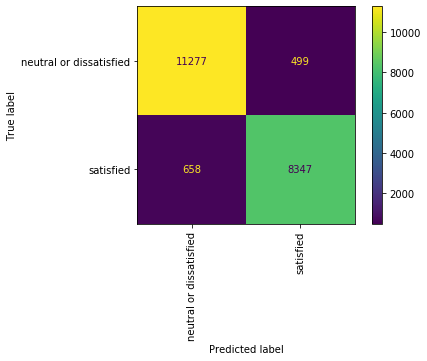

In [13]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, val[features], val[target], values_format='.0f', xticks_rotation='vertical');

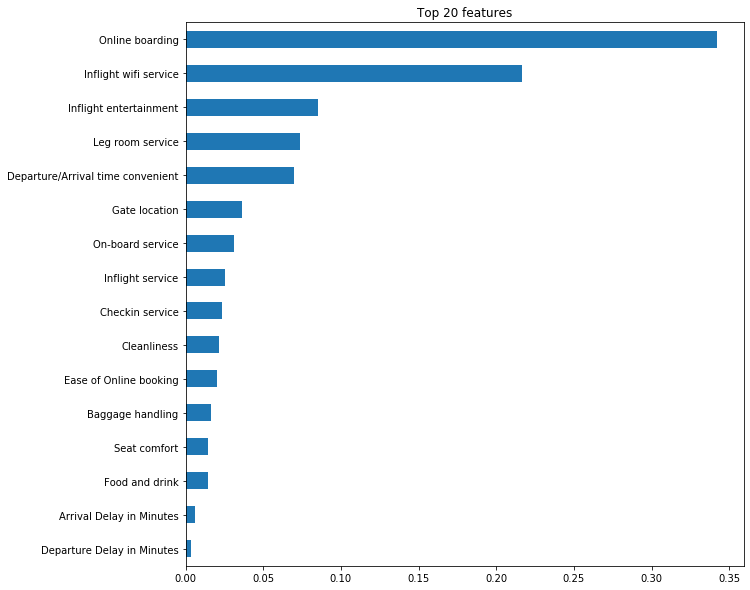

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(train[features])

# Get feature importances
rf = pipeline.named_steps['xgbclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [20]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipeline, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(val[features], val[target])

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('ordinalencoder',
                                                 OrdinalEncoder(cols=[],
                                                                drop_invariant=False,
                                                                handle_missing='value',
                                                                handle_unknown='value',
                                                                mapping=[],
                                                                return_df=True,
                                                                verbose=0)),
                                                ('xgbclassifier',
                                                 XGBClassifier(base_score=0.5,
                                                               booster='gbtree',
                                                  

In [23]:
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=val[features].columns.tolist() # must be a list
)

Weight,Feature
0.2074 ± 0.0032,Inflight wifi service
0.0609 ± 0.0014,Online boarding
0.0485 ± 0.0024,Gate location
0.0328 ± 0.0021,Departure/Arrival time convenient
0.0186 ± 0.0011,Leg room service
0.0183 ± 0.0011,Inflight entertainment
0.0167 ± 0.0024,Cleanliness
0.0148 ± 0.0012,Ease of Online booking
0.0132 ± 0.0013,Inflight service
0.0127 ± 0.0009,Checkin service
